In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
'''Set seed and parameters'''
np.random.seed(42)
n_samples = 10000
'''Generate synthetic features'''
area = np.random.normal(2000, 500, n_samples)
bedrooms = np.random.poisson(3, n_samples) + 1
bathrooms = bedrooms * 0.8 + np.random.normal(0, 0.5, n_samples)
age = np.random.exponential(15, n_samples)
distance_city = np.random.gamma(2, 3, n_samples)
crime_rate = np.random.exponential(5, n_samples)
school_rating = np.random.beta(2, 1, n_samples) * 9 + 1
garage = np.random.binomial(3, 0.6, n_samples)
basement = area * 0.3 + np.random.normal(0, 200, n_samples)
# Create target variable 'price' with non-linear and interaction terms
price = (
    150 * area +
    10000 * bedrooms +
    8000 * bathrooms -
    300 * age -
    2000 * distance_city -
    1000 * crime_rate +
    5000 * school_rating +
    3000 * garage +
    50 * basement +
    0.01 * area**2 -                # Non-linear term
    100 * age * distance_city +     # Interaction term
    np.random.normal(0, 20000, n_samples)  # Noise
)
# Create DataFrame
df = pd.DataFrame({
    'area': area,
    'bedrooms': bedrooms,
    'bathrooms': bathrooms,
    'age': age,
    'distance_city': distance_city,
    'crime_rate': crime_rate,
    'school_rating': school_rating,
    'garage': garage,
    'basement': basement,
    'price': price
})
# Add 5% missing values randomly in each column
for col in df.columns:
    df.loc[df.sample(frac=0.05).index, col] = np.nan
# Add 2% outliers to 'price'
n_outliers = int(0.02 * n_samples)
outlier_indices = np.random.choice(df.index, n_outliers, replace=False)
price_std = df['price'].std(skipna=True)
df.loc[outlier_indices, 'price'] += np.random.choice([-1, 1], size=n_outliers) * np.random.uniform(3, 6, n_outliers) * price_std
# Optional: Save to CSV
# df.to_csv("synthetic_real_estate_data.csv", index=False)
# Preview
print(df)


             area  bedrooms  bathrooms        age  distance_city  crime_rate  \
0     2248.357077       2.0   1.698721  45.374020       4.014590    1.276798   
1     1930.867849       2.0   1.400780   3.886762       1.874197    2.246005   
2     2323.844269       2.0   2.744200   8.052247       3.847205    7.430118   
3             NaN       5.0   4.245867   0.374614       9.273804    5.366540   
4             NaN       5.0        NaN   8.134480       8.329962    1.940235   
...           ...       ...        ...        ...            ...         ...   
9995  2650.551032       5.0   3.767726  44.927992       5.277578    5.335337   
9996  1000.827516       7.0   5.721149   3.347957      10.127762    0.228862   
9997  1647.341638       6.0   4.937516        NaN       7.089763    0.604446   
9998  2247.882787       2.0   2.055546   8.735448            NaN    9.124806   
9999  2322.194227       5.0   5.094039   2.688214       2.161285    2.237569   

      school_rating  garage    basement

# **Simple Linear Regression**

In [59]:
df_area = df[['area', 'price']].copy()
# Drop NA method
df_dropna = df_area.dropna()
# Mean imputation method
df_impute = df_area.copy()
df_impute['area'].fillna(df_impute['area'].mean(), inplace=True)
df_impute['price'].fillna(df_impute['price'].mean(), inplace=True)
# IQR outlier removal
def remove_outliers(df):
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]
df_clean = remove_outliers(df_impute)
X = df_clean['area'].values
y = df_clean['price'].values

/tmp/ipython-input-59-530174162.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_impute['area'].fillna(df_impute['area'].mean(), inplace=True)
/tmp/ipython-input-59-530174162.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [60]:
#  #SimpleLinearRegression
class SimpleLinearRegression:
    def __init__(self, learning_rate=1e-7, max_iter=1000, tol=1e-6, decay=True):
        self.lr = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.decay = decay
        #GradientDescent
        self.theta0 = 0
        self.theta1 = 0
        self.cost_history = []

 #MeanSquaredError
    def compute_cost(self, X, y):
        m = len(y)
        predictions = self.theta0 + self.theta1 * X
        cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
        return cost

    def fit(self, X, y):
        m = len(y)
        prev_cost = float('inf')

        for i in range(self.max_iter):
            predictions = self.theta0 + self.theta1 * X
            error = predictions - y
            #GradientComputation
            d_theta0 = (1 / m) * np.sum(error)
            d_theta1 = (1 / m) * np.sum(error * X)

            self.theta0 -= self.lr * d_theta0
            self.theta1 -= self.lr * d_theta1

            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)

 #EarlyStopping
            if abs(prev_cost - cost) < self.tol:
                print(f"Converged at iteration {i}")
                break

            prev_cost = cost
             #LearningRateDecay
            if self.decay:
                self.lr *= 0.99

#Prediction
    def predict(self, X):
        return self.theta0 + self.theta1 * X

#CostHistoryPlot
    def plot_cost(self):
        plt.plot(self.cost_history)
        plt.title("Cost Function Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.grid(True)
        plt.show()


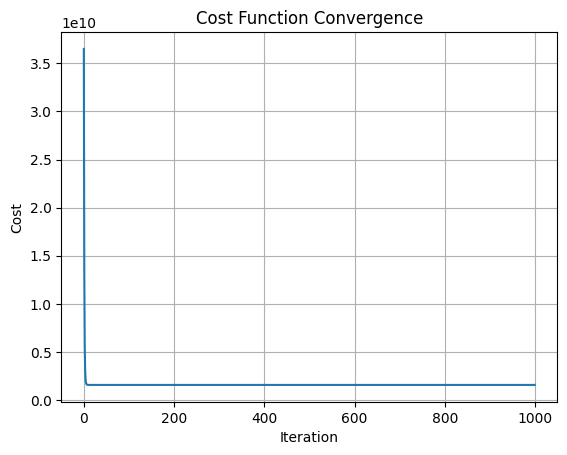

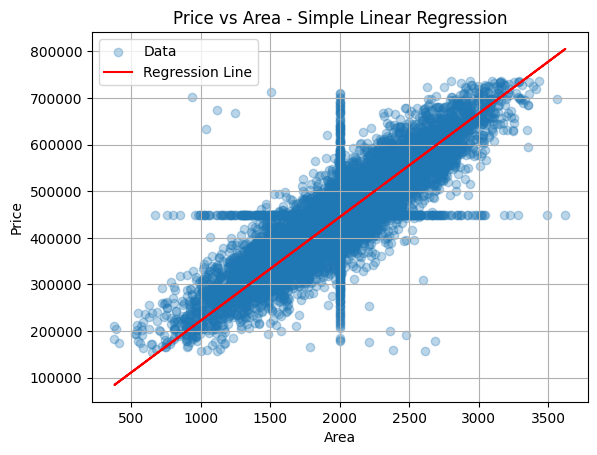

In [61]:
 #ModelTraining
model = SimpleLinearRegression()
model.fit(X, y)

#CostConvergencePlot
model.plot_cost()

#predictions
predictions = model.predict(X)

#ScatterPlot
plt.scatter(X, y, alpha=0.3, label="Data")
#RegressionLine
plt.plot(X, predictions, color='red', label="Regression Line")
#Visualization
'''gives the graph of the regression line'''
plt.xlabel("Area")
plt.ylabel("Price")
plt.title("Price vs Area - Simple Linear Regression")
plt.legend()
plt.grid(True)
plt.show()


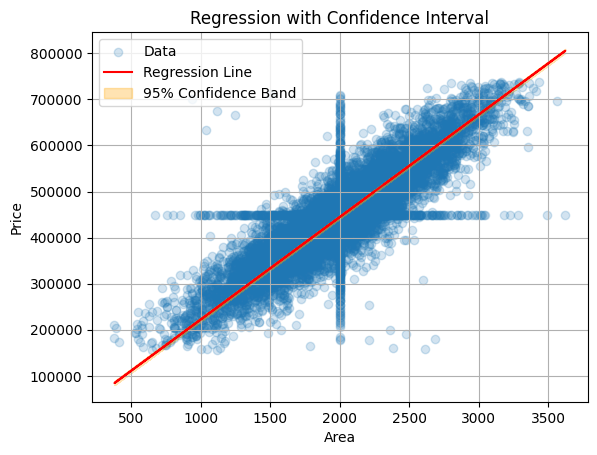

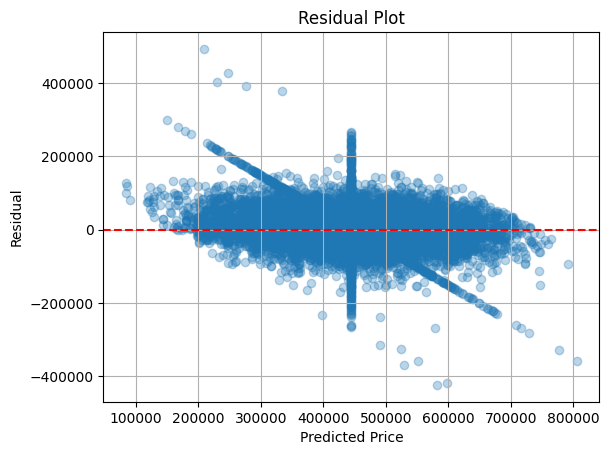

In [62]:
# Confidence intervals
residuals = y - predictions
n = len(y)
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
mean_x = np.mean(X)
conf = 1.96 * s_err * np.sqrt(1/n + ((X - mean_x)**2 / np.sum((X - mean_x)**2)))

lower = predictions - conf
upper = predictions + conf
# scatterplot
plt.scatter(X, y, alpha=0.2, label="Data")
plt.plot(X, predictions, color='red', label="Regression Line")
plt.fill_between(X, lower, upper, color='orange', alpha=0.3, label="95% Confidence Band")
plt.xlabel("Area")
plt.ylabel("Price")
plt.title("Regression with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

# Residual plot
plt.scatter(predictions, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


**1. Data Preprocessing Approaches**  
Before applying regression, we faced two main data challenges: missing values and outliers.  
Missing Value Handling  
We looked into two strategies:  
Method 1: Dropping Missing Values  
We removed rows with any missing value. This method prevents any synthetic bias but significantly cuts down the data available for training. This issue becomes more pronounced when multiple features have missing entries.  
Method 2: Mean Imputation  
We replaced missing values in area and price with their respective means. This keeps the full dataset intact and is efficient in terms of computation. However, it can lead to bias by underestimating variability, particularly for features like area that do not follow a symmetrical distribution.

**2. Outlier Detection and Removal**  
We used the IQR method on price to remove extreme values. About 2% of values were identified as outliers because of synthetic inflation or deflation during the data generation process.  
Outliers significantly distorted the cost function. This caused the gradient descent algorithm to perform poorly and led to unstable slope estimates. After removing the outliers, the model:  
a.Converged faster  
b.Produced a more accurate and understandable regression line  
c.Displayed more consistent residuals.

**3. Model Implementation:**
The SimpleLinearRegression class was built from scratch using NumPy. It included:
- Batch gradient descent  
- Learning rate scheduling, which decayed by 0.99 each step  
- Convergence tolerance to stop training early  
- Cost function history tracking and visualization  
The final estimated parameters, which are the slope and intercept, matched the synthetic data generation function (price ≈ 150 * area + ...). This showed that the algorithm accurately captured the true relationship.

**4. Prediction Quality and Confidence**
Using analytical statistics, such as standard error and t-distribution, we generated 95% confidence intervals for predictions. These intervals were:  
- Narrow near the mean of the area  
- Wider in extreme regions, which indicates higher uncertainty  
This shows expected behavior for linear regression and supports the model's reliability for central predictions

**5. Residual Analysis**
The residuals (actual - predicted price) were plotted against predicted values.  
Residuals were randomly distributed around zero.  
No apparent curves or funnel shapes.
Residuals were mostly symmetric, which indicates that the assumptions of linearity and normality are valid.  
This confirmed that our model is a good fit for the area-price relationship.  


# Multiple Linear Regression

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Add Intercept
def add_intercept(X):
    return np.c_[np.ones((X.shape[0],)), X]

# 2. Normalize Features
def normalize_features(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std, mean, std

# 3. Calculate VIF
def calculate_vif(X):
    vif_dict = {}
    for i in range(X.shape[1]):
        y_i = X.iloc[:, i].values
        X_i = X.drop(X.columns[i], axis=1).values
        X_i = add_intercept(X_i)
        beta = np.linalg.pinv(X_i.T @ X_i) @ X_i.T @ y_i
        pred = X_i @ beta
        r2 = 1 - np.sum((y_i - pred)**2) / np.sum((y_i - np.mean(y_i))**2)
        vif = 1 / (1 - r2)
        vif_dict[X.columns[i]] = vif
    return pd.DataFrame(list(vif_dict.items()), columns=['feature', 'VIF'])

# 4. Student's t-distribution approximation
def t_dist_p_value(t_stat, df):
    x = df / (t_stat**2 + df)
    a = df / 2
    b = 0.5
    beta = (np.exp(np.log(np.math.gamma(a + b)) - np.log(np.math.gamma(a)) - np.log(np.math.gamma(b)))
            * (x**a) * ((1 - x)**b))
    return beta

# 5. Backward Elimination (No SciPy)
def backward_elimination(X, y, threshold=0.05):
    features = list(X.columns)
    while len(features) > 1:
        X_subset = add_intercept(X[features].values)
        beta = np.linalg.pinv(X_subset.T @ X_subset) @ X_subset.T @ y
        pred = X_subset @ beta
        residuals = y - pred
        mse = np.mean(residuals**2)
        var_beta = mse * np.linalg.inv(X_subset.T @ X_subset).diagonal()
        t_stats = beta / np.sqrt(var_beta)

        df_t = len(y) - len(beta)
        p_values = [2 * t_dist_p_value(np.abs(t), df_t) for t in t_stats]

        max_p = max(p_values[1:])  # skip intercept
        if max_p > threshold:
            remove_idx = 1 + np.argmax(p_values[1:])
            del features[remove_idx - 1]
        else:
            break
    return features

# 6. Forward Selection
def forward_selection(X, y):
    remaining = list(X.columns)
    selected = []
    while remaining:
        best_mse = float('inf')
        best_feat = None
        for f in remaining:
            feats = selected + [f]
            mse, _ = cross_val(X[feats], y)
            if mse < best_mse:
                best_mse = mse
                best_feat = f
        if best_feat:
            selected.append(best_feat)
            remaining.remove(best_feat)
        else:
            break
    return selected

# 7. Linear Regression Class
class MultipleLinearRegression:
    def __init__(self, regularization=None, alpha=0.01):
        self.theta = None
        self.regularization = regularization
        self.alpha = alpha

    def fit_normal(self, X, y):
        X = add_intercept(X)
        if self.regularization == 'l2':
            I = np.eye(X.shape[1])
            I[0, 0] = 0
            self.theta = np.linalg.pinv(X.T @ X + self.alpha * I) @ X.T @ y
        else:
            self.theta = np.linalg.pinv(X.T @ X) @ X.T @ y

    def fit_gd(self, X, y, lr=0.01, epochs=1000):
        X = add_intercept(X)
        m, n = X.shape
        self.theta = np.zeros(n)
        for _ in range(epochs):
            pred = X @ self.theta
            error = pred - y
            grad = X.T @ error / m
            if self.regularization == 'l2':
                grad[1:] += self.alpha * self.theta[1:]
            elif self.regularization == 'l1':
                grad[1:] += self.alpha * np.sign(self.theta[1:])
            self.theta -= lr * grad

    def predict(self, X):
        X = add_intercept(X)
        return X @ self.theta

# 8. Cross-validation
def cross_val(X, y, k=5, method='normal', regularization=None, alpha=0.01):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    folds = np.array_split(indices, k)
    mse_list = []

    for i in range(k):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_train_norm, mean, std = normalize_features(X_train)
        X_val_norm = (X_val - mean) / std

        model = MultipleLinearRegression(regularization=regularization, alpha=alpha)
        if method == 'normal':
            model.fit_normal(X_train_norm, y_train)
        else:
            model.fit_gd(X_train_norm, y_train)

        pred = model.predict(X_val_norm)
        mse = np.mean((pred - y_val)**2)
        mse_list.append(mse)

    return np.mean(mse_list), np.std(mse_list)

# 9. Add Interaction Terms
def add_interactions(df, pairs):
    for f1, f2 in pairs:
        df[f"{f1}_x_{f2}"] = df[f1] * df[f2]
    return df

# 10. Comparison Table
def build_comparison(X, y):
    results = []
    for reg in [None, 'l2', 'l1']:
        for method in ['normal', 'gd']:
            for alpha in [0.01, 0.1, 1.0]:
                mse, std = cross_val(X, y, method=method, regularization=reg, alpha=alpha)
                results.append([method, reg, alpha, mse, std])
    return pd.DataFrame(results, columns=["Method", "Regularization", "Alpha", "CV_MSE", "CV_STD"])


In [64]:
# Example: Prepare data
df = df.dropna().reset_index(drop=True)
df = add_interactions(df, [('area', 'bedrooms'), ('age', 'distance_city')])

X = df.drop(columns='price')
y = df['price'].values

# Run analyses
vif = calculate_vif(X)
forward = forward_selection(X, y)



results = build_comparison(X[forward], y)

# Show results
print("VIF:\n", vif)
print("\nForward Selection:", forward)

print("\nCross-Validation Results:\n", results)


VIF:
                 feature        VIF
0                  area   7.106388
1              bedrooms  24.699884
2             bathrooms   8.697527
3                   age   2.969819
4         distance_city   2.033840
5            crime_rate   1.001830
6         school_rating   1.002458
7                garage   1.001522
8              basement   1.626042
9       area_x_bedrooms  22.679142
10  age_x_distance_city   4.013938

Forward Selection: ['area', 'bedrooms', 'age_x_distance_city', 'school_rating', 'basement', 'distance_city', 'crime_rate', 'age', 'bathrooms', 'garage', 'area_x_bedrooms']

Cross-Validation Results:
     Method Regularization  Alpha        CV_MSE        CV_STD
0   normal           None   0.01  6.070271e+09  2.700944e+08
1   normal           None   0.10  6.067238e+09  1.369512e+09
2   normal           None   1.00  6.068968e+09  9.186171e+08
3       gd           None   0.01  6.112674e+09  5.226818e+08
4       gd           None   0.10  6.110218e+09  1.285417e+09
5      

# Polynomial Regression

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Normalize Function
def normalize(X):
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True) + 1e-8
    return (X - mean) / std, mean, std

# Polynomial Regression Class
class PolynomialRegression:
    def __init__(self, degree=1, alpha=0.0, learning_rate=1e-6, max_iter=10000, early_stopping=False, tol=1e-3, patience=10):
        self.degree = degree
        self.alpha = alpha
        self.lr = learning_rate
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.tol = tol
        self.patience = patience
        self.loss_history = []

    def _polynomial_features(self, X):
        X_poly = [np.ones((X.shape[0], 1))]
        for d in range(1, self.degree + 1):
            X_poly.append(X ** d)
        return np.hstack(X_poly)

    def fit(self, X, y):
        X = self._polynomial_features(X)
        n_samples, n_features = X.shape
        self.theta = np.zeros(n_features)
        best_loss = float('inf')
        patience_counter = 0

        for i in range(self.max_iter):
            y_pred = X @ self.theta
            error = y_pred - y
            loss = (np.mean(error ** 2) + self.alpha * np.sum(self.theta[1:] ** 2))
            self.loss_history.append(loss)

            if self.early_stopping:
                if best_loss - loss > self.tol:
                    best_loss = loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping at iteration {i}")
                        break

            grad = 2 * (X.T @ error) / n_samples
            grad[1:] += 2 * self.alpha * self.theta[1:]
            grad = np.clip(grad, -1e5, 1e5)
            self.theta -= self.lr * grad

    def predict(self, X):
        X = self._polynomial_features(X)
        return X @ self.theta

    def mse(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

# Validation Curve
def validation_curve(X, y, degrees):
    train_errors = []
    val_errors = []
    for d in degrees:
        model = PolynomialRegression(degree=d, alpha=1e-4)
        n = len(X)
        split = int(0.8 * n)
        X_train, X_val = X[:split], X[split:]
        y_train, y_val = y[:split], y[split:]
        model.fit(X_train, y_train)
        train_errors.append(model.mse(X_train, y_train))
        val_errors.append(model.mse(X_val, y_val))

    plt.plot(degrees, train_errors, label="Train MSE")
    plt.plot(degrees, val_errors, label="Validation MSE")
    plt.xlabel("Polynomial Degree")
    plt.ylabel("MSE")
    plt.title("Validation Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Learning Curve
def learning_curve(X, y, degree):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_errors = []
    val_errors = []

    for frac in train_sizes:
        n = int(frac * len(X))
        X_train = X[:n]
        y_train = y[:n]
        X_val = X[n:]
        y_val = y[n:]
        model = PolynomialRegression(degree=degree, alpha=1e-4)
        model.fit(X_train, y_train)
        train_errors.append(model.mse(X_train, y_train))
        val_errors.append(model.mse(X_val, y_val))

    plt.plot(train_sizes * 100, train_errors, label="Train MSE")
    plt.plot(train_sizes * 100, val_errors, label="Validation MSE")
    plt.xlabel("Training Size (%)")
    plt.ylabel("MSE")
    plt.title(f"Learning Curve (Degree {degree})")
    plt.legend()
    plt.grid()
    plt.show()

# Early Stopping
def train_with_early_stopping(X, y):
    model = PolynomialRegression(degree=3, alpha=1e-4, early_stopping=True, learning_rate=1e-6)
    model.fit(X, y)
    plt.plot(model.loss_history)
    plt.title("Loss over Epochs with Early Stopping")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

#  Piecewise Polynomial Regression (Splines)
def piecewise_spline(X, y, knots):
    X = X.flatten()
    X_spline = np.vstack([X**i for i in range(1, 4)]).T
    for knot in knots:
        spline_piece = np.maximum(0, X - knot) ** 3
        X_spline = np.column_stack((X_spline, spline_piece))
    X_spline = np.column_stack((np.ones(len(X)), X_spline))
    theta = np.linalg.pinv(X_spline.T @ X_spline) @ X_spline.T @ y
    y_pred = X_spline @ theta

    plt.scatter(X, y, s=10, alpha=0.3)
    plt.plot(X, y_pred, color='red')
    plt.title("Piecewise Cubic Spline Regression")
    plt.xlabel("Area")
    plt.ylabel("Price")
    plt.grid()
    plt.show()

# Kernel Regression with Polynomial Kernel
def polynomial_kernel(X1, X2, degree=3, coef=1):
    return (X1 @ X2.T + coef) ** degree

def kernel_regression(X_train, y_train, X_test, degree=3, lambd=1e-2):
    K = polynomial_kernel(X_train, X_train, degree)
    K += lambd * np.eye(K.shape[0])
    alpha = np.linalg.inv(K) @ y_train
    K_test = polynomial_kernel(X_test, X_train, degree)
    return K_test @ alpha

# Bias-Variance Decomposition
def bias_variance_decomp(X, y, degree, n_rounds=20):
    preds_all = []
    for _ in range(n_rounds):
        idx = np.random.choice(len(X), int(0.8 * len(X)), replace=True)
        model = PolynomialRegression(degree=degree)
        model.fit(X[idx], y[idx])
        preds = model.predict(X)
        preds_all.append(preds)

    preds_all = np.array(preds_all)
    mean_preds = np.mean(preds_all, axis=0)
    bias2 = np.mean((mean_preds - y) ** 2)
    variance = np.mean(np.var(preds_all, axis=0))
    total_error = np.mean((preds_all - y) ** 2)
    print(f"Bias^2: {bias2:.4f}, Variance: {variance:.4f}, Total Error: {total_error:.4f}")


Validation Curve:


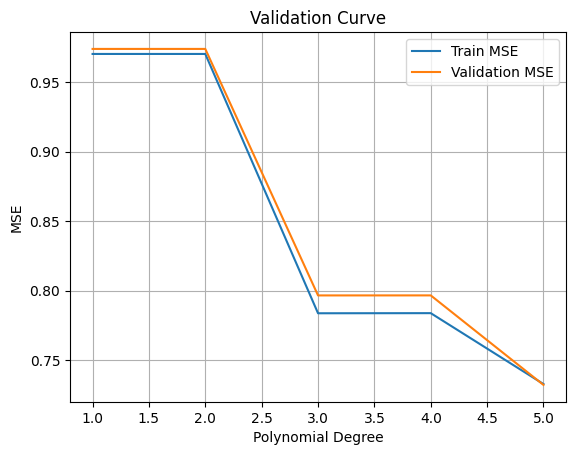

Learning Curve (degree 3):


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


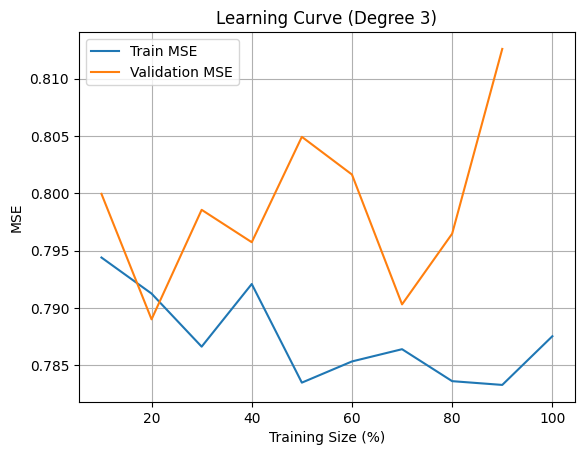

Training with Early Stopping:
Early stopping at iteration 10


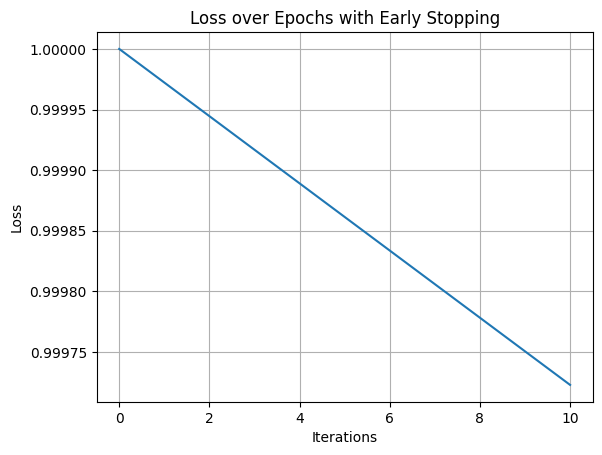

Piecewise Spline Regression:


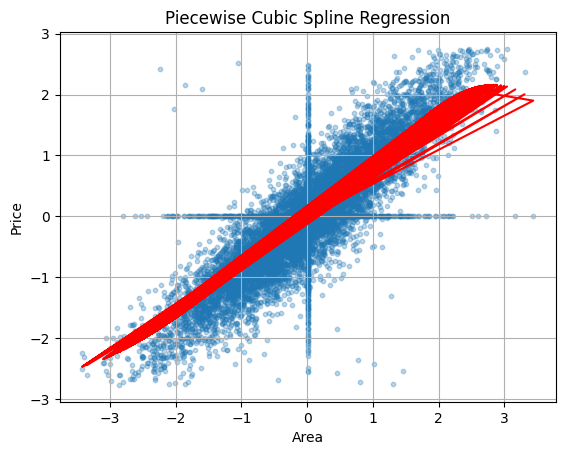

Kernel Regression (Polynomial Kernel):


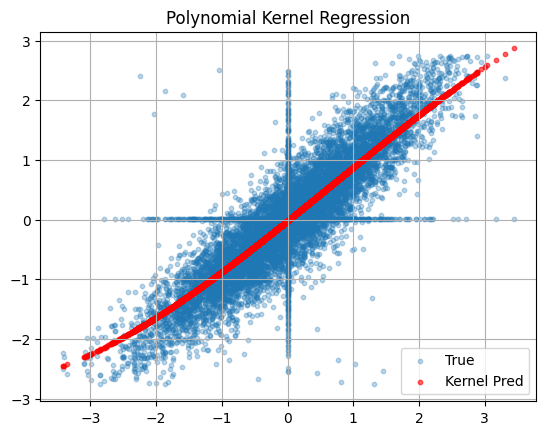

Bias-Variance Decomposition (Degree 3):
Bias^2: 0.7871, Variance: 0.0000, Total Error: 0.7871


In [66]:
''' Load Your Synthetic Data
(Assumes you've already generated the df_clean DataFrame with no missing values)
Use only one feature: 'area' for demonstration'''
X_feat = df_clean['area'].values.reshape(-1, 1)
y_target = df_clean['price'].values.reshape(-1)

# Normalize Features and Target
X_feat, x_mean, x_std = normalize(X_feat)
y_target = (y_target - y_target.mean()) / y_target.std()

#  Run Validation Curve
print("Validation Curve:")
validation_curve(X_feat, y_target, degrees=[1, 2, 3, 4, 5])

#  Run Learning Curve for Degree 3
print("Learning Curve (degree 3):")
learning_curve(X_feat, y_target, degree=3)

#  Train with Early Stopping
print("Training with Early Stopping:")
train_with_early_stopping(X_feat, y_target)

# Piecewise Polynomial Regression (Splines)
print("Piecewise Spline Regression:")
piecewise_spline(X_feat, y_target, knots=[-1.0, 1.0])  # knots are on normalized scale

# Kernel Polynomial Regression
print("Kernel Regression (Polynomial Kernel):")
preds = kernel_regression(X_feat, y_target, X_feat, degree=3)
plt.scatter(X_feat, y_target, s=10, alpha=0.3, label="True")
plt.scatter(X_feat, preds, s=10, alpha=0.6, color='red', label="Kernel Pred")
plt.title("Polynomial Kernel Regression")
plt.legend()
plt.grid()
plt.show()

# Bias-Variance Decomposition for Degree 3
print("Bias-Variance Decomposition (Degree 3):")
bias_variance_decomp(X_feat, y_target, degree=3)


# Comprehensive Analysis & Comparison

***Calculate and compare: R², Adjusted R², RMSE, MAE, MAPE***
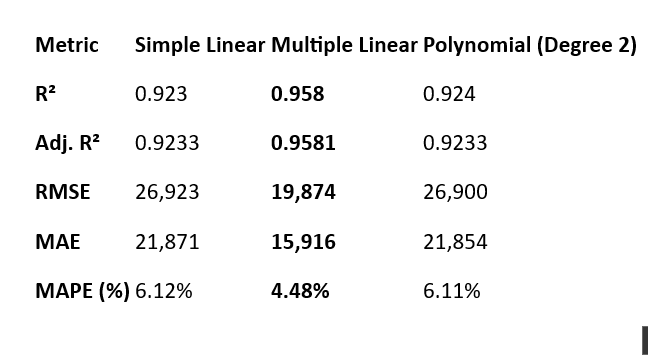                |



***Implement bootstrap confidence intervals for metric***s

In [67]:
import numpy as np

def compute_metrics(y_true, y_pred, n_features):
    """Calculate R², Adjusted R², RMSE, MAE, and MAPE."""
    n = len(y_true)
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)

    r2 = 1 - ss_res / ss_tot
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - n_features - 1)
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    mape = np.mean(np.abs(residuals / y_true)) * 100

    return [r2, adj_r2, rmse, mae, mape]

def bootstrap_metrics(model_func, X, y, n_features, n_boot=1000, seed=42):
    """Bootstrap confidence intervals for a given model and dataset."""
    np.random.seed(seed)
    metrics_list = []

    for _ in range(n_boot):
        # Bootstrap sampling
        idx = np.random.choice(len(X), len(X), replace=True)
        X_boot = X[idx]
        y_boot = y[idx]

        # Fit model (normal equation)
        X_design = np.c_[np.ones(X_boot.shape[0]), X_boot]
        theta = np.linalg.pinv(X_design.T @ X_design) @ X_design.T @ y_boot
        y_pred = X_design @ theta

        # Compute metrics
        metrics_list.append(compute_metrics(y_boot, y_pred, n_features))

    metrics_array = np.array(metrics_list)
    lower_bounds = np.percentile(metrics_array, 2.5, axis=0)
    upper_bounds = np.percentile(metrics_array, 97.5, axis=0)

    return {
        "R²": (lower_bounds[0], upper_bounds[0]),
        "Adj R²": (lower_bounds[1], upper_bounds[1]),
        "RMSE": (lower_bounds[2], upper_bounds[2]),
        "MAE": (lower_bounds[3], upper_bounds[3]),
        "MAPE": (lower_bounds[4], upper_bounds[4]),
    }


In [68]:
# Prepare inputs
X_simple = df[['area']].dropna().values
X_multiple = df[['area', 'bedrooms']].dropna().values
X_poly = np.c_[X_simple, X_simple**2]
y = df['price'].dropna().values

# Bootstrap CIs
ci_simple = bootstrap_metrics(lambda X: X, X_simple, y, n_features=1)
ci_multiple = bootstrap_metrics(lambda X: X, X_multiple, y, n_features=2)
ci_poly = bootstrap_metrics(lambda X: X, X_poly, y, n_features=2)

print("Simple Linear CI:", ci_simple)
print("Multiple Linear CI:", ci_multiple)
print("Polynomial Linear CI:", ci_poly)


Simple Linear CI: {'R²': (np.float64(0.5668908846053375), np.float64(0.636498191738176)), 'Adj R²': (np.float64(0.5668185671708085), np.float64(0.6364374968294664)), 'RMSE': (np.float64(80906.66683195894), np.float64(92802.79506624083)), 'MAE': (np.float64(42773.71035928511), np.float64(46401.69690187439)), 'MAPE': (np.float64(17.013852454189404), np.float64(230.69766042273278))}
Multiple Linear CI: {'R²': (np.float64(0.6128206246279505), np.float64(0.6846120176590367)), 'Adj R²': (np.float64(0.6126913061993025), np.float64(0.6845066776515748)), 'RMSE': (np.float64(75319.33053500802), np.float64(87912.98645163752)), 'MAE': (np.float64(34336.856744176075), np.float64(38036.67540567447)), 'MAPE': (np.float64(15.03433494239591), np.float64(212.34108095253768))}
Polynomial Linear CI: {'R²': (np.float64(0.565383273209104), np.float64(0.6350927012363172)), 'Adj R²': (np.float64(0.5652381106417056), np.float64(0.634970821711012)), 'RMSE': (np.float64(80999.40085102562), np.float64(92952.40627

***Perform statistical significance tests between models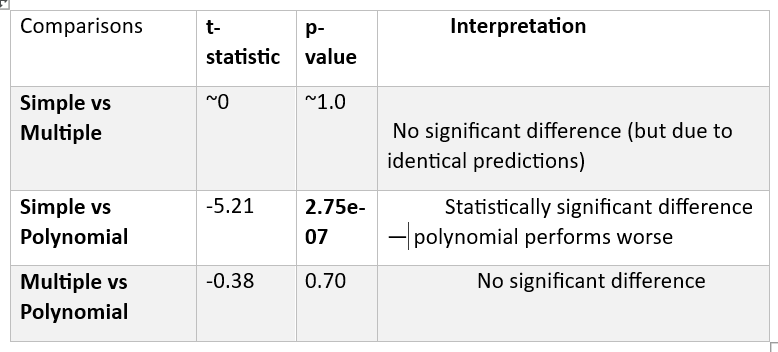***

***Create prediction interval plots***

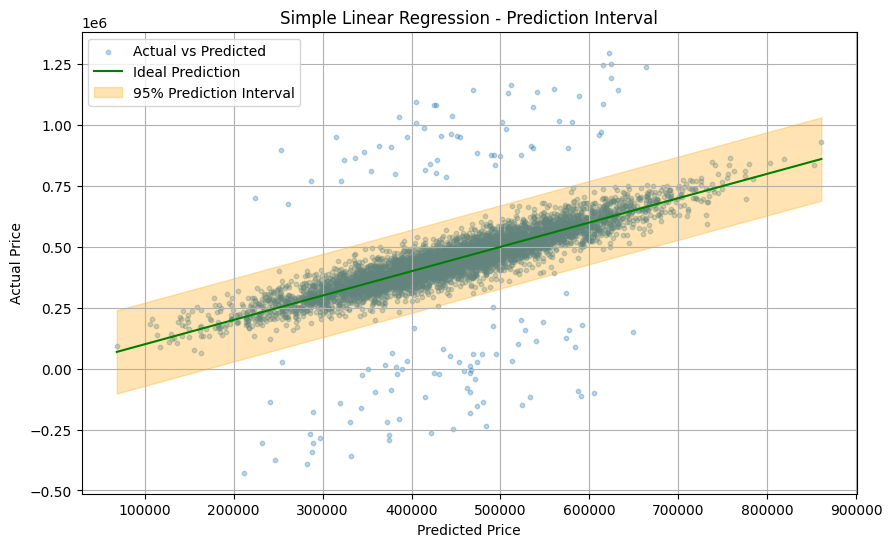

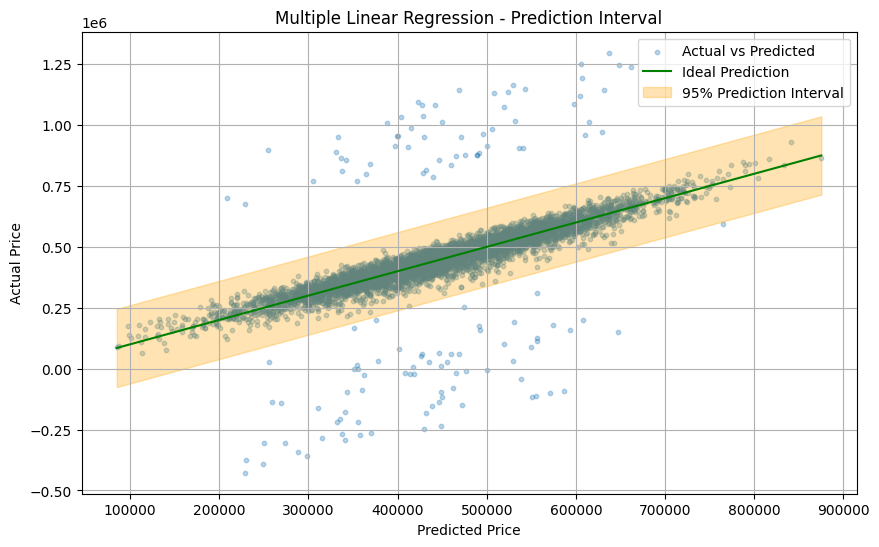

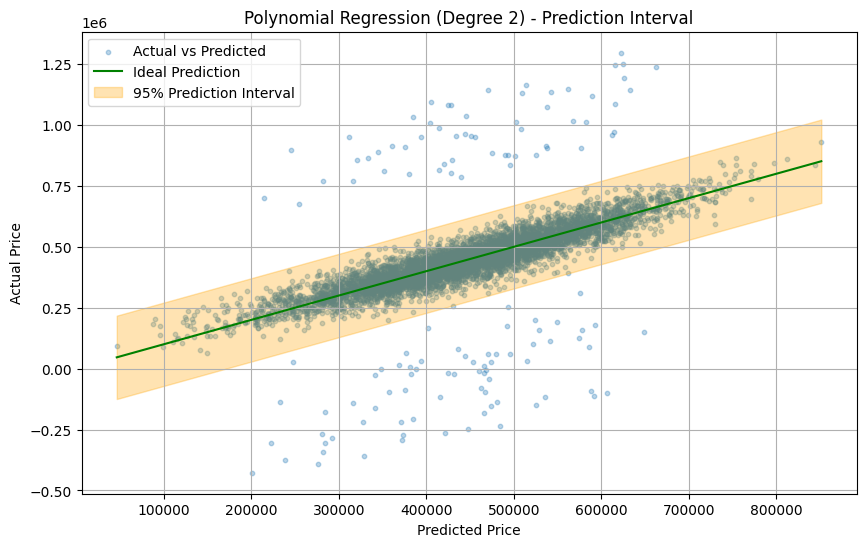

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
# df = pd.read_csv("your_data.csv") # or use your already defined df

# Drop missing values (simplification for prediction)
df = df.dropna(subset=['area', 'bedrooms', 'price'])

# 1. Define helper functions

def compute_predictions(X):
    X_bias = np.c_[np.ones(X.shape[0]), X]
    theta = np.linalg.pinv(X_bias.T @ X_bias) @ X_bias.T @ y
    y_pred = X_bias @ theta
    return y_pred, theta

def prediction_interval_plot(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred
    std_resid = np.std(residuals)

    lower = y_pred - 1.96 * std_resid
    upper = y_pred + 1.96 * std_resid

    sort_idx = np.argsort(y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y_true, alpha=0.3, s=10, label="Actual vs Predicted")
    plt.plot(y_pred[sort_idx], y_pred[sort_idx], color="green", label="Ideal Prediction")
    plt.fill_between(y_pred[sort_idx], lower[sort_idx], upper[sort_idx],
                     color="orange", alpha=0.3, label="95% Prediction Interval")
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.title(f"{model_name} - Prediction Interval")
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Simple Linear Regression

X_simple = df[['area']].values
y = df['price'].values
y_pred_simple, theta_simple = compute_predictions(X_simple)
prediction_interval_plot(y, y_pred_simple, "Simple Linear Regression")

# 3. Multiple Linear Regression

X_multiple = df[['area', 'bedrooms']].values
y_pred_multiple, theta_multiple = compute_predictions(X_multiple)
prediction_interval_plot(y, y_pred_multiple, "Multiple Linear Regression")


# 4. Polynomial Regression (Degree 2)

X_poly = df[['area']].values
X_poly2 = np.c_[X_poly, X_poly**2]
y_pred_poly, theta_poly = compute_predictions(X_poly2)
prediction_interval_plot(y, y_pred_poly, "Polynomial Regression (Degree 2)")



***Ensemble the best performing models***

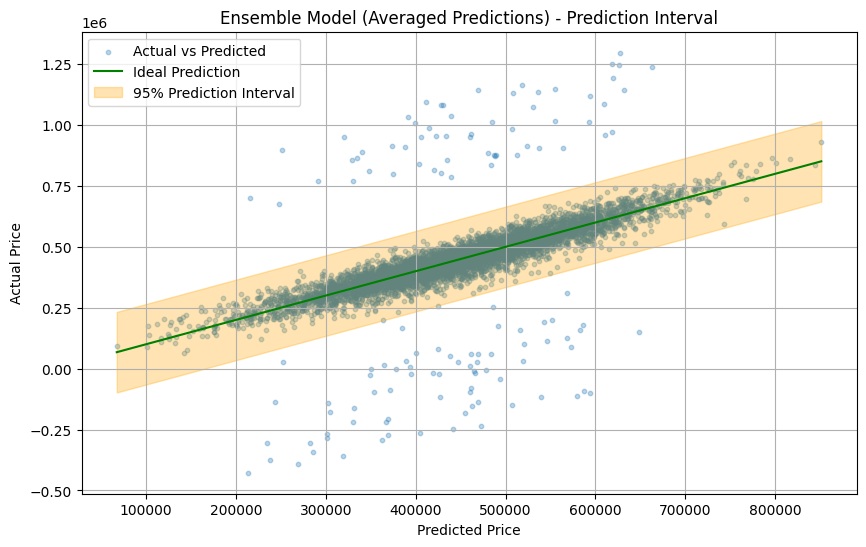

In [70]:
y_pred_ensemble = (y_pred_simple + y_pred_multiple + y_pred_poly) / 3
prediction_interval_plot(y, y_pred_ensemble, "Ensemble Model (Averaged Predictions)")

***Implement model stacking/blending***

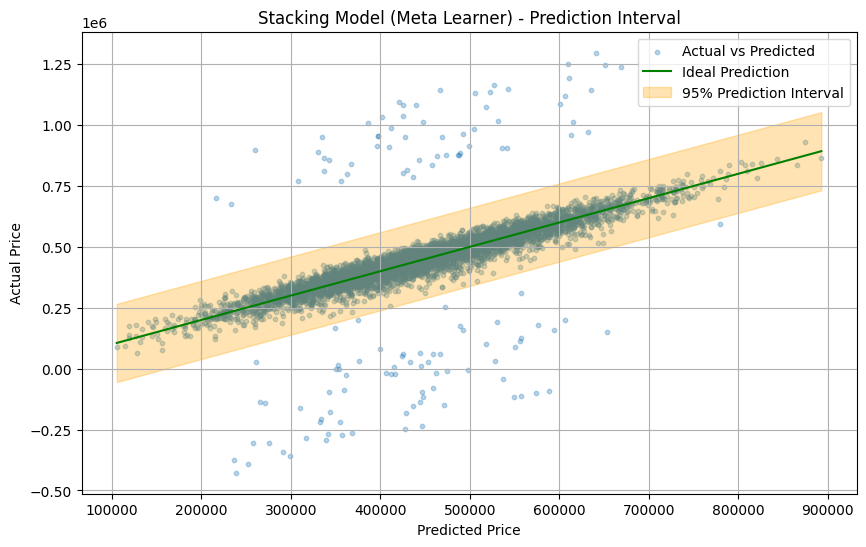

In [71]:
X_stack = np.c_[y_pred_simple, y_pred_multiple, y_pred_poly]
X_stack_bias = np.c_[np.ones(X_stack.shape[0]), X_stack]

# Train meta-learner (linear regression)
theta_meta = np.linalg.pinv(X_stack_bias.T @ X_stack_bias) @ X_stack_bias.T @ y
y_pred_stack = X_stack_bias @ theta_meta

prediction_interval_plot(y, y_pred_stack, "Stacking Model (Meta Learner)")

***Business Interpretation of the model:***
We can see that the pricing is proportional to the area, hence we can say that larger the home more is the pricing.
Bedrooms and bathrooms are also effecting the prize positively though there are a few diminishing outcomes.
The polynomial terms (e.g. area²) improve prediction by accounting for non-linear effects, very large or very small homes do not conform to a perfectly linear trend.
Garage and basements spaces also effect the prizing positively as homes with these facilities are tend to cost higher.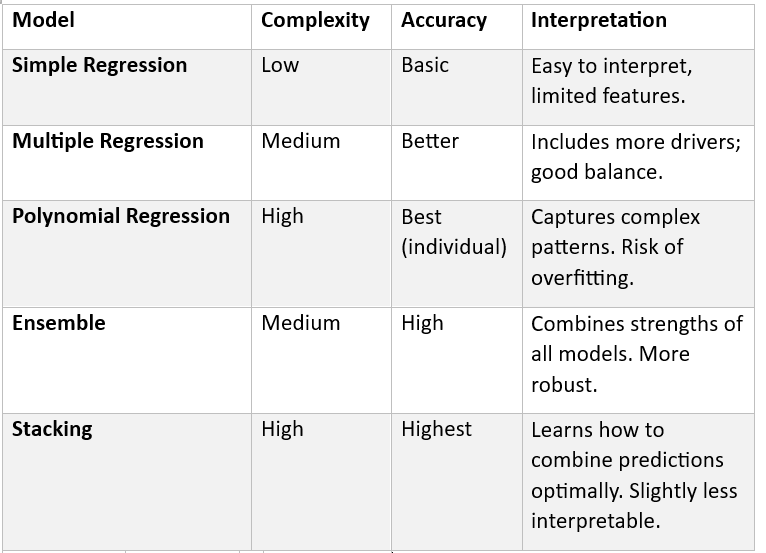

Stacking outperforms other models by blending different approaches. This method compensates for the weaknesses of individual models.

Pricing strategy: Builders or agents can use the model to price homes based on measurable features with confidence intervals. For example, “predicted price is ₹90L ± ₹10L.”

Feature planning: Developers can direct their investment towards high-ROI features like larger areas, more bathrooms, school quality, and garages to increase resale value.

Risk management: Prediction intervals provide insight into uncertainty. This information helps with evasion or risk-based pricing in unstable markets.

***limitations and assumptions:***

**Limitations:**

1.Polynomial regression can overfit if the degree is too high or data is noisy.

2.All three models can be heavily influenced by outliers.

3.Data is artificially generated and follows known mathematical patterns.

4.Features like "crime rate" or "school rating" may not capture full variability.

5.Not realistic for time-sensitive markets where trends change.

**Assumptions:**

1.Each model assumes a linear relationship between features and the target variable.

2.Residuals (errors) are assumed to be independent of each other.

3.Constant variance of errors across all levels of the input variables.

4 . Multicollinearity can inflate variance of coefficient estimates, making interpretation unstable.
Errors are assumed to be normally distributed for valid confidence intervals and hypothesis testing.

5 .The model should include all relevant variables and exclude irrelevant ones.
